In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts

import matplotlib.pyplot as plt

from scipy.stats import shapiro
from statsmodels.stats.multitest import multipletests

pd.set_option('display.max_columns', None)

### Useful functions

In [ ]:
def filter_by_features(contacts_df,
                       energy_type,
                       mutation_type,
                       # contacting_parts,
                       chain_type='both',
                       clean_missing_energy=True):
    """
    Filters the contacts table by specified features

    Parameters
    ----------
    contacts_df : DataFrame
        Contacts table
    energy_type : str
        
    mutation_type : str
        "Mutated" or "Mutated_repacked"
    contacting_parts : str
        _description_
    chain_type : str, optional
        _description_, by default 'both'
    clean_missing_energy : bool, optional
        If True, deletes contacts with missing energy, by default True

    Returns
    -------
    filtered_df : DataFrame
        Filtered contacts
    """
    filtered_df = contacts_df.copy()
    filtered_df = filtered_df[filtered_df['energy.type'] == energy_type].drop('energy.type', 1)
    if 'mutation.type' in filtered_df.columns:
        filtered_df = filtered_df[filtered_df['mutation.type'] == mutation_type].drop('mutation.type', 1)
    else:
        warnings.warn('Mutation type is not reported in dataset')
    if clean_missing_energy: 
        filtered_df = filtered_df[filtered_df['byres.energy'] != 'none']
        filtered_df.loc[:,'byres.energy'] = filtered_df['byres.energy'].astype(np.float64)
    
    if chain_type != 'both':
        filtered_df = filtered_df[filtered_df['chain.type'] == chain_type]
        
    # Для глицинов брать ВСЁ
    filtered_df = filtered_df[
        (filtered_df['rin.contact.part'] == 'SC_SC') |                                                                # both side chains or
        (filtered_df['resname.tcr'] == 'G') | #& filtered_df['rin.contact.part'].apply(lambda s: s.startswith('MC')) |   # cdr3 glycine main chain or
        (filtered_df['resname.peptide'] == 'G') #& filtered_df['rin.contact.part'].apply(lambda s: s.endswith('MC'))   # peptide glycine main chain
    ]
        
    filtered_df.reset_index(inplace=True)

    return filtered_df

In [5]:
def weights_by_enegy(energy):
    ENERGY_THRESHOLD = -3 
    
    T = 273    # K
    kT = 1.987 * 10**-3 * T    # kcal / mol
    energy[energy < ENERGY_THRESHOLD] = ENERGY_THRESHOLD    # Cut off outliers
    return np.exp(-energy / kT)

In [6]:
# For concatenation multiple dataframes by common columns
# Important! Before you need to bring the names of important features to uniformity

def stack_by_common_features(data_frames: list[pd.DataFrame]):
    common_col_names = set(data_frames[0].columns)
    for df in data_frames[1:]:
        common_col_names &= set(df.columns)
        
    common_columns = [feature for feature in data_frames[0].columns if feature in common_col_names]
    return pd.concat([df[common_columns] for df in data_frames], ignore_index=True, axis=0)

# Notes

* Для каждого из остатков TCR оставить только контакт с минимальным расстоянием/энергией
* Проверить структуры пдб на предмет внесения мутаций в остатки, вносящие наибольший вклад в связывание (оригинальные данные из таблицы normal, сравнивать можно по номеру остатка) 
* Done. Прислать соображение по оценке контактов (резюме: что можно использовать, а что нет и почему) сегодня

In [ ]:
Гипотеза: если контакты в оригинальной структуре очень важные, то они скорее всего не мутировались

Сравнить структуры, полученные разной последовательностью мутаций с точки зрения контактов (одинаковые или нет)

# Reading and filtering data

In [30]:
# Reading data
contacts_df = pd.read_csv('Mutated_Models_w_NEW_PATH_04_2022_contacts_w_descriptors.csv')
# contacts_df.drop('Unnamed: 0', 1, inplace=True)    # Removing artefact column
contacts_df.rename(columns={'resn.mut.to': 'resname.tcr'}, inplace=True)

In [54]:
# # Reading data
# contacts_df_1 = pd.read_csv('normal_pdbs_CDR3_contacts_energy_RIN_descriptors.csv')
# contacts_df_1 = contacts_df_1[
#     (contacts_df_1['complex.species'] == 'Human')
#     & (contacts_df_1['mhc.type'] == 'MHCI')
# ]

In [61]:
# Merge multiple inputs

# contacts_df = stack_by_common_features([contacts_df_0, contacts_df_1])
# contacts_df = contacts_df_0

In [10]:
# Extracting descriptor names
cdr3_indices = np.hstack((contacts_df.columns[-94:-89], contacts_df.columns[-84:-42]))
peptide_indices = np.hstack((contacts_df.columns[-89:-84], contacts_df.columns[-42:]))

index_names = np.array([name[5:] for name in cdr3_indices])

<AxesSubplot:>

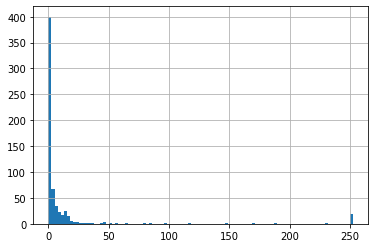

In [31]:
# Filtering and adding weights
contacts_filtered = filter_by_features(contacts_df, energy_type='OLD', mutation_type='Mutated_repacked', chain_type='both')
contacts_filtered['weights'] = weights_by_enegy(contacts_filtered['byres.energy'])

contacts_filtered['weights'].hist(bins=100)

# Defining groups by properties

In [16]:
index_nature = pd.read_excel('indices.xlsx', index_col='index_name')
indices = index_nature.index
index_nature = ~index_nature.isna()

for prop in index_nature.columns:
    print('\t', prop)
    print()
    for ind in index_nature.index[index_nature[prop]]:
        print(ind)
    print()

	 Hydrophobicity

Z1
PP2
F1
VHSE1
VHSE2
Blos1
KF4
KF10

	 Steric_properties

atcley.ms
Z2
F3
VHSE3
VHSE4
Blos1
Blos2
Blos3
KF2

	 Electronic_properties

atcley.pah
atcley.ec
Z3
PP1
F6
VHSE5
VHSE6
VHSE7
VHSE8

	 Structure

atcley.pss
F2
Blos1
Blos3
KF1
KF3
KF5
KF8



# PCA analysis

In [100]:
from sklearn.decomposition import PCA

In [101]:
N_COMPONENTS = 10

descriptor_names = np.hstack((cdr3_indices, peptide_indices))
descriptors = contacts_filtered[descriptor_names]
descriptors /= descriptors.std(axis=0)    # normalization of descriptor variance

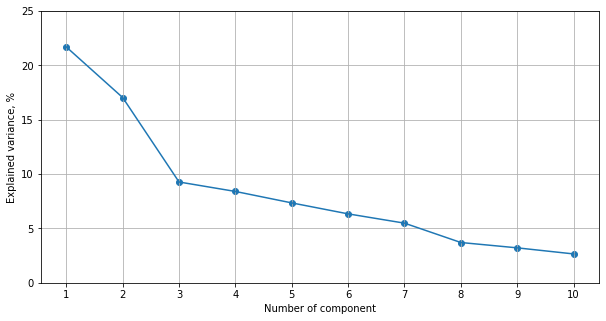

In [102]:
pca = PCA(n_components=N_COMPONENTS)
pca.fit(descriptors)

explained_variance_percent = pca.explained_variance_ratio_ * 100
component_number = np.arange(1, N_COMPONENTS+1)

plt.figure(figsize=(10,5))
plt.plot(component_number, explained_variance_percent)
plt.scatter(component_number, explained_variance_percent)
plt.xticks(component_number)
plt.xlabel('Number of component')
plt.ylabel('Explained variance, %')
plt.ylim(0, 25)
plt.grid()
plt.show()

In [110]:
# Is square root necessary here???

components = pd.DataFrame(pca.components_ * pca.explained_variance_[:,None]**0.5, columns=descriptor_names)    # Considering components length
components_properties = pd.DataFrame(index=components.index, columns=index_nature.columns)

for prop in index_nature.columns:
    prop_columns = descriptor_names[np.hstack((index_nature[prop], index_nature[prop]))]
    prop_df = components[prop_columns]
    components_properties.loc[:,prop] = np.linalg.norm(prop_df, axis=1)
    
# Normalization by the contribution to the overall variation (if needed) 
# components_properties /= components_properties.sum(axis=1).values[:,None]

components_properties

,Hydrophobicity,Steric_properties,Electronic_properties,Structure
0,2.418461,2.360730,1.540760,1.751178
1,1.433404,2.178010,1.673390,1.741531
2,1.188148,1.028760,1.758966,1.069845
3,1.677001,1.267008,1.184442,0.997942
4,1.073365,1.163112,1.379542,0.898705
5,0.364441,0.915928,1.144969,1.030193
6,0.616561,0.963825,0.995108,1.153825
7,0.555710,0.430176,1.175644,0.884268
8,0.368792,0.360792,0.673878,0.961693
9,0.375942,0.288847,0.474182,0.848947


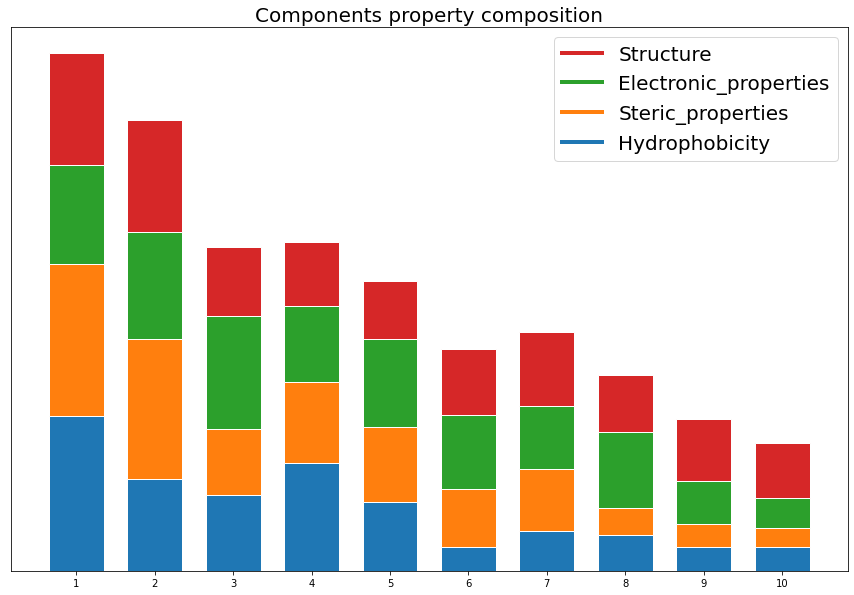

In [111]:
from matplotlib.lines import Line2D

plt.figure(figsize=(15,10))
plt.xticks(component_number)
plt.yticks([])

bottom = np.zeros(N_COMPONENTS)
custom_lines = []
i = 0
for prop in index_nature.columns:
    layer_heigth = components_properties[prop] #* explained_variance_percent
    plt.bar(component_number, layer_heigth, bottom=bottom, edgecolor='white', width=0.7, color=f'C{i}')
    custom_lines.append(Line2D([0], [0], color=f'C{i}', lw=4))
    bottom += layer_heigth
    i += 1
    
plt.legend(custom_lines[::-1], index_nature.columns[::-1], fontsize=20)
plt.title('Components property composition', fontsize=20)
plt.show()

In [113]:
# Contacts of charged residues

# charged_res = ['E', 'D', 'K', 'R', 'H']
# df = contacts_filtered[contacts_filtered['resname.peptide'].isin(charged_res) & contacts_filtered['resname.tcr'].isin(charged_res)]
# df

# Correlation analysis

In [62]:
def pairwise_correlation_of_indices(df, cdr3_indices, peptide_indices, method='pearson'):
    return (df[np.hstack((cdr3_indices, peptide_indices))]
            .corr(method=method)
            .loc[cdr3_indices, peptide_indices])

In [34]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr_w(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def pairwise_correlation_of_indices_weighted(df, cdr3_indices, peptide_indices, 
                                             weights='weights'):
    corr_df = pd.DataFrame(index=cdr3_indices, columns=peptide_indices, dtype=np.float32)
    W = df[weights]
    for cdr_ind in cdr3_indices:
        for pep_ind in peptide_indices:
            corr_df.loc[cdr_ind, pep_ind] = corr_w(
                df[cdr_ind],
                df[pep_ind],
                df[weights]
            )
    
    return corr_df

In [95]:
def corr_analysis(contacts_df, index_nature=None, is_weighted=False, text_size=25, figscale=1):
    if index_nature is None:
        index_nature = pd.DataFrame(index=index_names)
        index_nature[''] = True
        figscale = 2
        
        
    corr_count_func = pairwise_correlation_of_indices_weighted if is_weighted else pairwise_correlation_of_indices

    fig, ax = plt.subplots(4, index_nature.columns.size + 1,
                           figsize=np.array((index_nature.columns.size*7 + 0.2, 11.2)) * figscale,
                           gridspec_kw={'width_ratios': [7]*index_nature.columns.size + [0.2],
                                        'height_ratios': [0.1, 7, 4, 0.1]})

    corr_list = []
    max_corr = 0
    for prop in index_nature.columns:
        corr_list.append(corr_count_func(
            contacts_df,
            cdr3_indices[index_nature[prop]],
            peptide_indices[index_nature[prop]],
        ))
        max_corr = max(max_corr, corr_list[-1].abs().max().max())
    
    i = 0
    for prop in index_nature.columns:
        corr = corr_list[i]
        ax_prop = ax[:,i]
        ax_prop[0].text(0.5, 0, 
                        prop,
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=text_size,
                       )
        
        ax_prop[0].set_axis_off()

        corr_values = corr.values.flatten()
        N = corr_values.size

        t_stats = corr_values * np.sqrt((N - 2) / (1 - corr_values**2))
        corr_p_values = 1 - sts.t.cdf(np.abs(t_stats), N-2)


        # print(prop)
        # alpha=0.05
        # print('Sign:', multipletests(corr_p_values, alpha/2)[0].mean())
        # print(corr_values.min(), corr_values.max())
        # print()

        sns.heatmap(corr**2, vmin=0, vmax=max_corr**2, square=True, 
                    ax=ax_prop[1], cbar_ax=ax[1,-1])
        ax_prop[1].set_title("Pearson's R^2" + " weighted by contact energy" if is_weighted else "")
        ax_prop[1].tick_params(axis='x', rotation=90)

        sns.histplot(corr.values.flatten(), bins=index_nature[prop].sum(), ax=ax_prop[2])
        ax_prop[2].set_title('Pearson correlation coefficients distribution')

        ax_prop[3].text(0.5, 1, 
                        f'Shapiro-Wilk Test p-value = {shapiro(corr.values.flatten())[1]:.3f}',
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=text_size-5,
                       )
        ax_prop[3].set_axis_off()

        i += 1

    ax[0,-1].set_axis_off()
    ax[2,-1].set_axis_off()
    ax[3,-1].set_axis_off()

    # fig.tight_layout()
    plt.subplots_adjust(left=0.1,
                        bottom=0.02, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()

## Unweighted

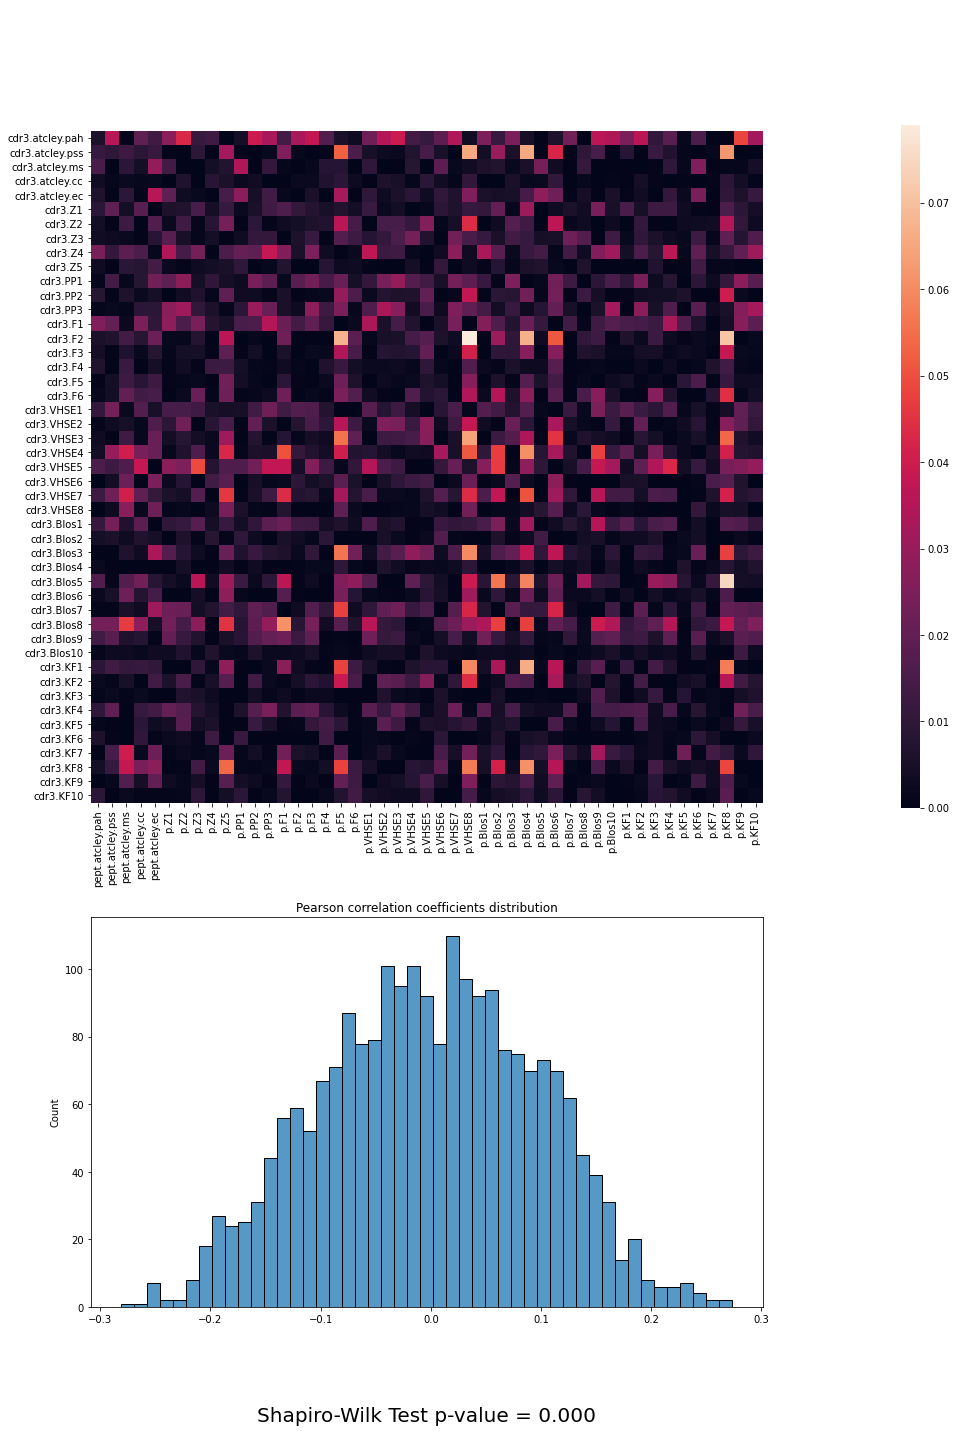

In [96]:
corr_analysis(contacts_filtered)

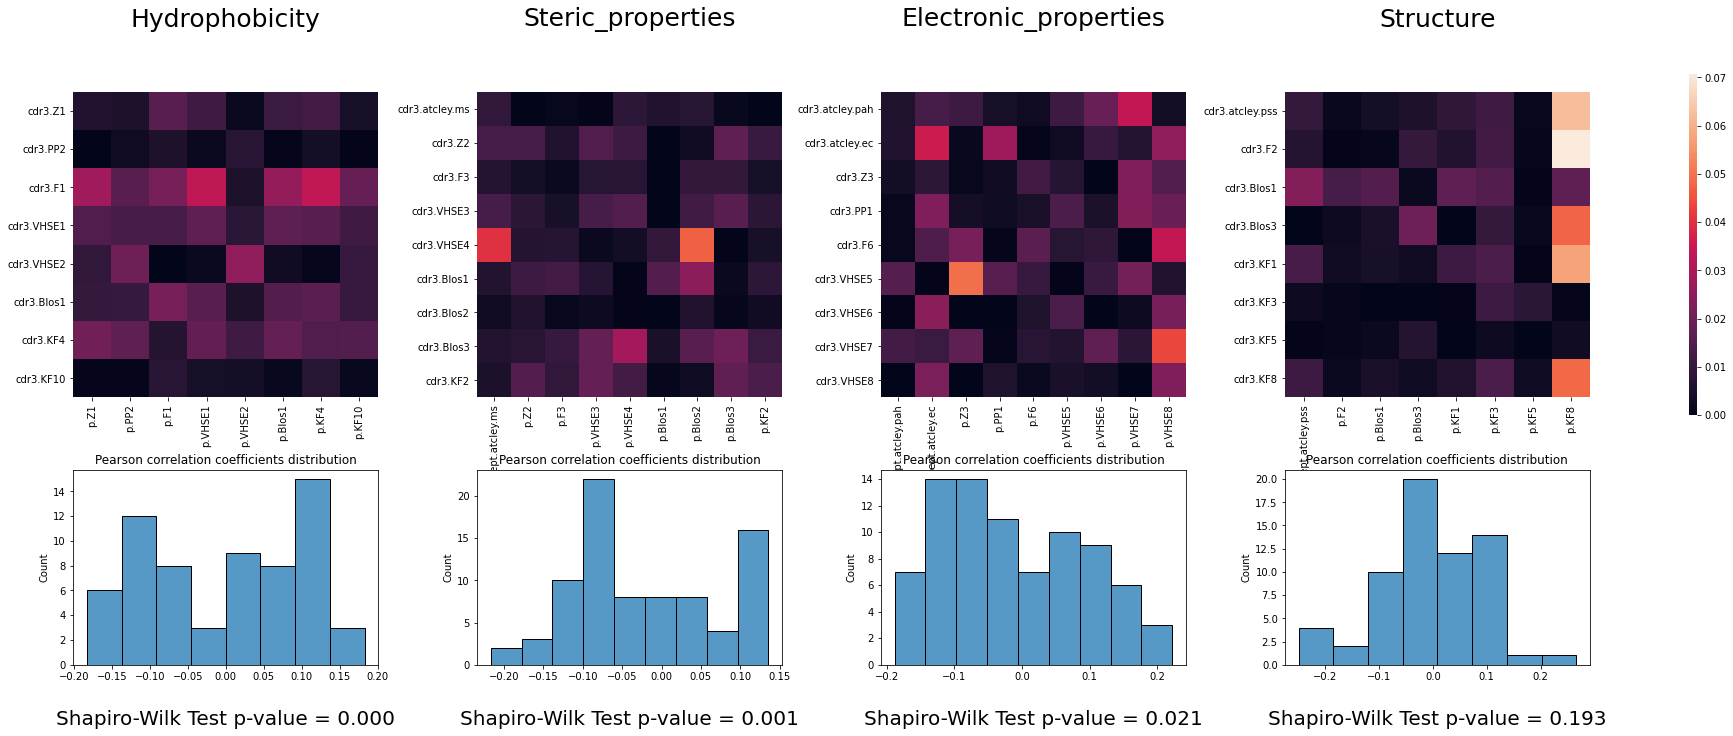

In [97]:
corr_analysis(contacts_filtered, index_nature)

## Weighted

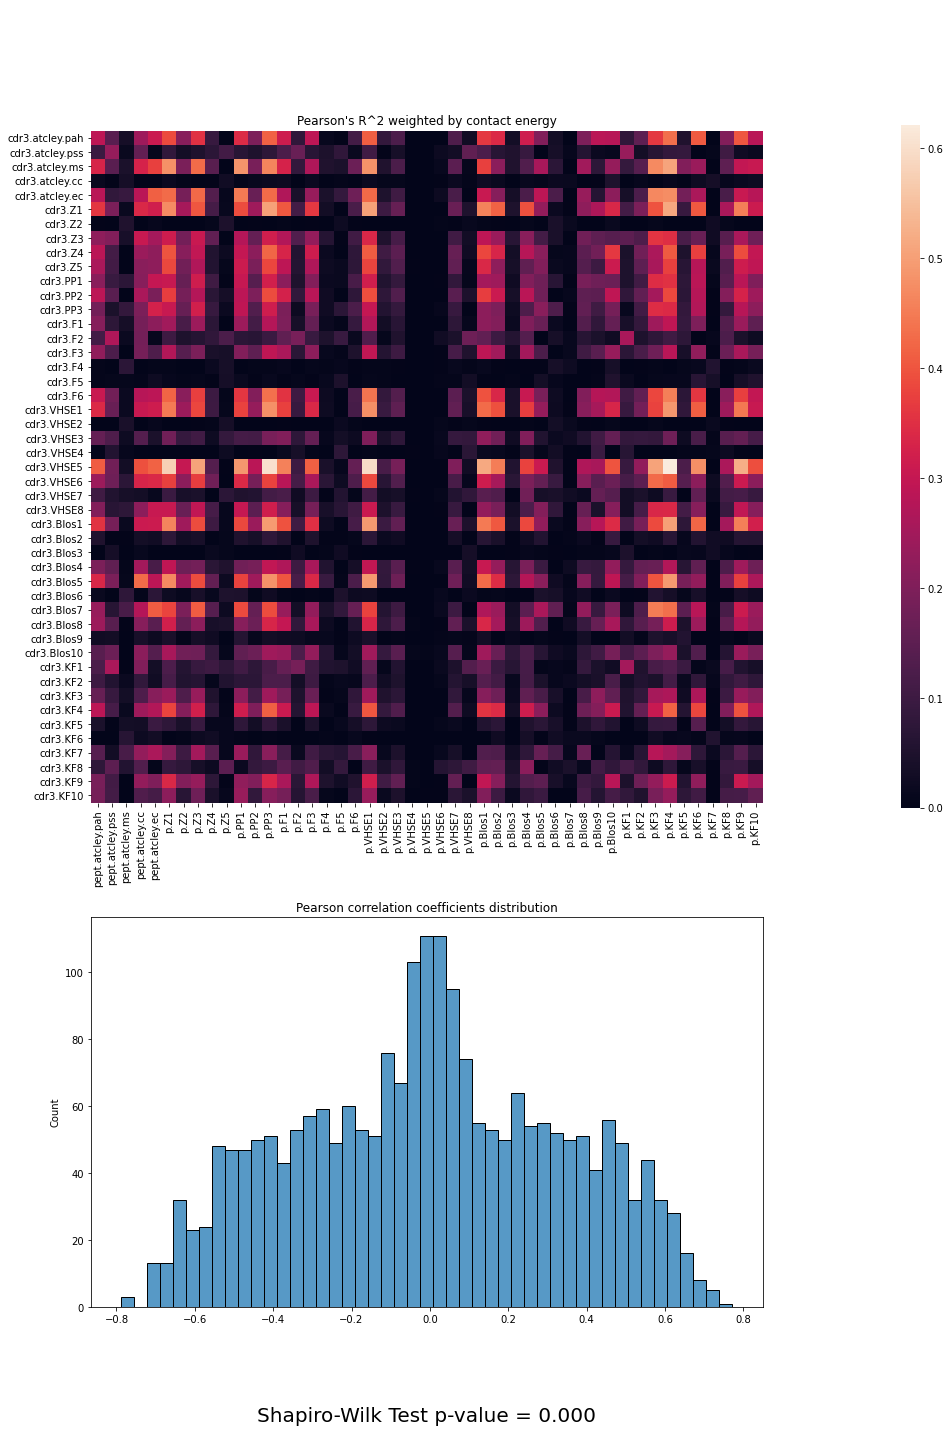

In [98]:
corr_analysis(contacts_filtered, is_weighted=True)

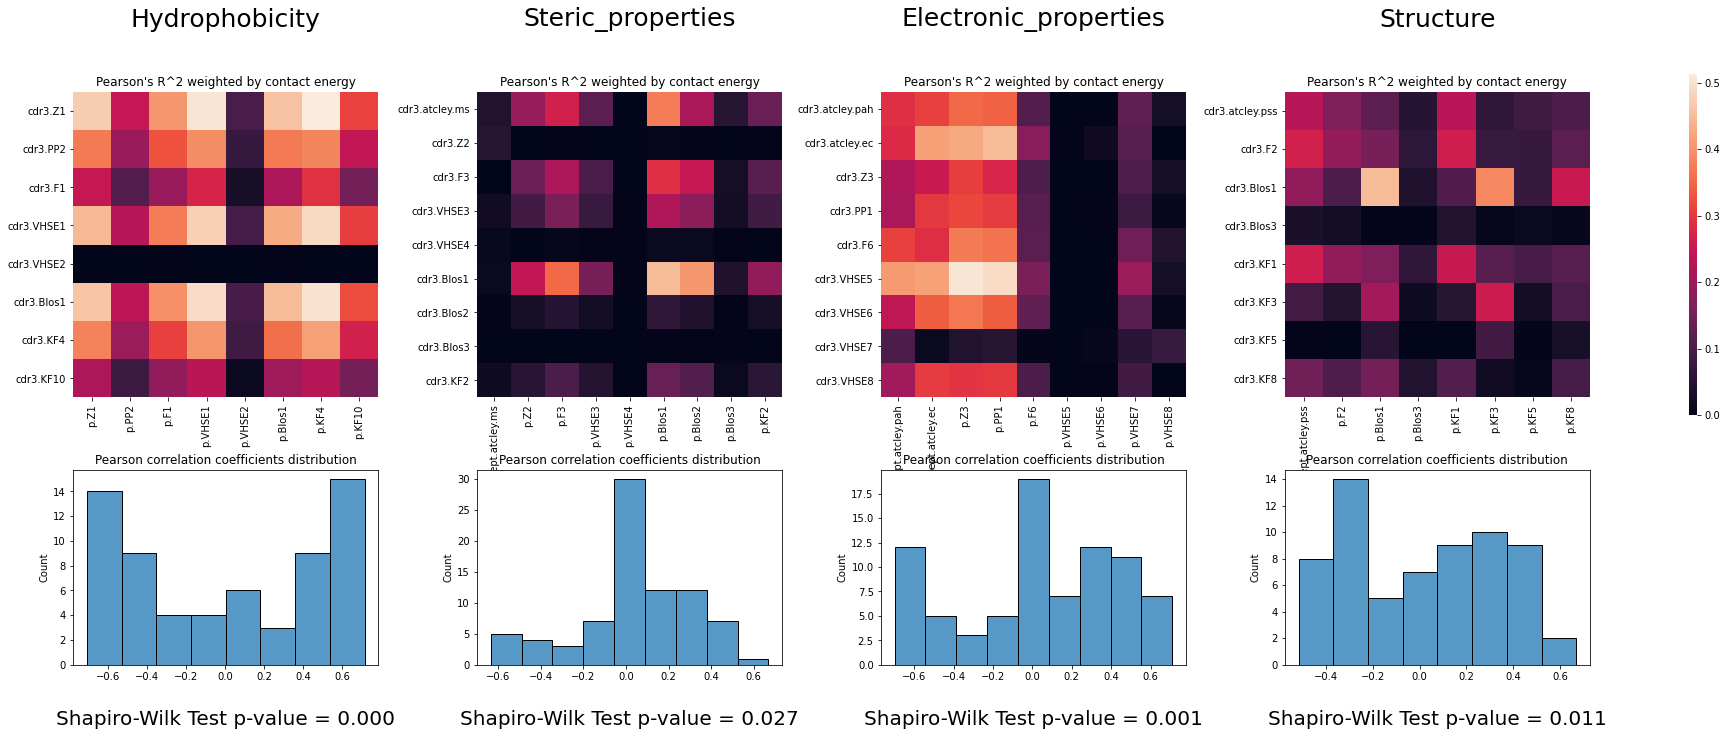

In [99]:
corr_analysis(contacts_filtered, index_nature, is_weighted=True)

# New

### Original structures

In [ ]:
original_structures = pd.read_csv('normal_pdbs_CDR3_contacts_energy_RIN_descriptors.csv')
original_structures = original_structures[
    (original_structures['complex.species'] == 'Human')
    & (original_structures['mhc.type'] == 'MHCI')
    & (original_structures['energy.type'] == 'OLD')
]
original_structures['pdb_id'] = [s[:s.find('_')] for s in original_structures['pdb.id']]
# original_structures

In [ ]:
# original_structures.columns[original_structures.columns.str.contains('dist')]
original_structures.columns[original_structures.columns.str.contains('atom')]

Index(['atom.tcr.contact', 'atom.peptide.contact'], dtype='object')

In [ ]:
# Grouping

filtering_feature = ('byres.energy', '')[0]
original_structures_grouped = original_structures.groupby(['pdb_id', 'chain.type', 'resid.pdb.tcr', 'resname.tcr'])
original_structures_grouped.size()
original_structures_grouped.min(filtering_feature)

resid.peptide.pdb  resid.peptide  \
pdb_id chain.type resid.pdb.tcr resname.tcr                                     
1ao7   TRA        91            T                            5              4   
                  92            T                            5              4   
                  93            D                            4              3   
                  94            S                            4              3   
       TRB        92            R                            5              4   
...                                                        ...            ...   
7rtr   TRA        465           N                          371              4   
                  467           D                          370              3   
                  468           D                          370              3   
       TRB        577           D                          371              4   
                  578           I                          371              4   

                                             resid.tcr  min.distance  \
pdb_id chain.type resid.pdb.tcr resname.tcr                            
1ao7   TRA        91            T                   90      3.392938   
                  92            T                   91      4.441783   
                  93            D                   92      3.480754   
                  94            S                   93      2.887539   
       TRB        92            R                   91      3.196816   
...                                                ...           ...   
7rtr   TRA        465           N                   89      3.339744   
                  467           D                   91      3.393846   
                  468           D                   92      2.718309   
       TRB        577           D                   94      2.736732   
                  578           I                   95      3.487418   

                                                 dist  byres.energy  \
pdb_id chain.type resid.pdb.tcr resname.tcr                           
1ao7   TRA        91            T            3.392938      0.086256   
                  92            T            4.441783     -0.096827   
                  93            D            3.480754     -1.610620   
                  94            S            2.887539     -1.004290   
       TRB        92            R            3.196816      1.110960   
...                                               ...           ...   
7rtr   TRA        465           N            3.339744      0.193198   
                  467           D            3.393846     -1.132190   
                  468           D            2.718309     -4.699680   
       TRB        577           D            2.736732     -4.199500   
                  578           I            3.487418     -1.468530   

                                             total.energy  \
pdb_id chain.type resid.pdb.tcr resname.tcr                 
1ao7   TRA        91            T                -4.12868   
                  92            T                -4.12868   
                  93            D                -4.12868   
                  94            S                -4.12868   
       TRB        92            R                -9.52581   
...                                                   ...   
7rtr   TRA        465           N                -6.92515   
                  467           D                -6.92515   
                  468           D                -6.92515   
       TRB        577           D                -5.97757   
                  578           I                -5.97757   

                                             rin.contact.distance  \
pdb_id chain.type resid.pdb.tcr resname.tcr                         
1ao7   TRA        91            T                           3.393   
                  92            T                           5.016   
                  93            D                           

In [ ]:
max_contacts = 0
for group, frame in original_structures_grouped:
    max_contacts = max(max_contacts, frame.shape[0])
    if frame.shape[0] > 5:
        break
    # i += 1

# frame[['byres.energy', 'total.energy', 'min.distance', 'dist', 'rin.contact.distance', 'atom.tcr.contact', 'atom.peptide.contact']]
frame
# max_contacts

,resname.peptide,resname.tcr,pdb.id,complex.species,chain.tra,v.segm.tra,j.segm.tra,chain.trb,v.segm.trb,j.segm.trb,chain.mhca,allele.info.mhca,chain.mhcb,allele.info.mhcb,peptide.chain,peptide,mhc.type,chain.type,chain.id,resid.pdb.tcr,resn.tcr.3,resid.peptide.pdb,resn.pept.3,resid.peptide,resid.tcr,min.distance,energy.type,dist,tcr.region,byres.energy,total.energy,rin.contact.type,rin.contact.part,rin.contact.distance,atom.tcr.contact,atom.peptide.contact,cdr3.atcley.pah,cdr3.atcley.pss,cdr3.atcley.ms,cdr3.atcley.cc,cdr3.atcley.ec,pept.atcley.pah,pept.atcley.pss,pept.atcley.ms,pept.atcley.cc,pept.atcley.ec,cdr3.Z1,cdr3.Z2,cdr3.Z3,cdr3.Z4,cdr3.Z5,cdr3.PP1,cdr3.PP2,cdr3.PP3,cdr3.F1,cdr3.F2,cdr3.F3,cdr3.F4,cdr3.F5,cdr3.F6,cdr3.VHSE1,cdr3.VHSE2,cdr3.VHSE3,cdr3.VHSE4,cdr3.VHSE5,cdr3.VHSE6,cdr3.VHSE7,cdr3.VHSE8,cdr3.Blos1,cdr3.Blos2,cdr3.Blos3,cdr3.Blos4,cdr3.Blos5,cdr3.Blos6,cdr3.Blos7,cdr3.Blos8,cdr3.Blos9,cdr3.Blos10,cdr3.KF1,cdr3.KF2,cdr3.KF3,cdr3.KF4,cdr3.KF5,cdr3.KF6,cdr3.KF7,cdr3.KF8,cdr3.KF9,cdr3.KF10,p.Z1,p.Z2,p.Z3,p.Z4,p.Z5,p.PP1,p.PP2,p.PP3,p.F1,p.F2,p.F3,p.F4,p.F5,p.F6,p.VHSE1,p.VHSE2,p.VHSE3,p.VHSE4,p.VHSE5,p.VHSE6,p.VHSE7,p.VHSE8,p.Blos1,p.Blos2,p.Blos3,p.Blos4,p.Blos5,p.Blos6,p.Blos7,p.Blos8,p.Blos9,p.Blos10,p.KF1,p.KF2,p.KF3,p.KF4,p.KF5,p.KF6,p.KF7,p.KF8,p.KF9,p.KF10,pdb_id
328,A,L,3hg1_al2_clened,Human,D,TRAV12-2*01,TRAJ27*01,E,TRBV30*01,TRBJ2-2*01,A,HLA-A2,B,B2M,C,ELAGIGILTV,MHCI,TRB,E,98,LEU,3,ALA,2,97,3.322012,OLD,3.322012,CDR3,-0.230513,-5.45403,VDW,MC_SC,4.358,CD2,C,-1.018952,-0.986935,-1.504619,1.26583,-0.911812,-0.591460,-1.302093,-0.733065,1.570392,-0.145508,-4.28,-1.3,-1.49,-0.72,0.84,-0.9,0.03,-0.24,1.2,1.128,0.703,1.904,0.536,-0.141,1.36,0.07,0.36,-0.8,0.22,-1.37,0.08,-0.62,-1.41,-0.86,-0.88,-0.17,0.03,0.34,0.11,0.15,-0.44,-0.02,-1.04,0.0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93,0.24,-2.32,0.60,-0.14,1.30,-0.96,-0.76,0.31,0.207,0.821,-1.009,1.387,0.063,-0.600,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,-0.48,0.08,-0.92,0.53,0.00,0.24,0.19,0.66,-0.05,1.36,0.33,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.20,-0.08,0.21,-0.48,3hg1
2737,G,L,3hg1_al2_clened,Human,D,TRAV12-2*01,TRAJ27*01,E,TRBV30*01,TRBJ2-2*01,A,HLA-A2,B,B2M,C,ELAGIGILTV,MHCI,TRB,E,98,LEU,6,GLY,5,97,3.657741,OLD,3.657741,CDR3,0.101752,-5.45403,VDW,MC_MC,5.247,C,C,-1.018952,-0.986935,-1.504619,1.26583,-0.911812,-0.383880,1.652015,1.330102,1.044976,2.063856,-4.28,-1.3,-1.49,-0.72,0.84,-0.9,0.03,-0.24,1.2,1.128,0.703,1.904,0.536,-0.141,1.36,0.07,0.36,-0.8,0.22,-1.37,0.08,-0.62,-1.41,-0.86,-0.88,-0.17,0.03,0.34,0.11,0.15,-0.44,-0.02,-1.04,0.0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93,2.05,-4.06,0.36,-0.82,-0.38,-0.88,-1.00,0.49,-0.205,-2.219,-1.656,1.229,-1.115,-1.146,-0.20,-1.53,-2.63,2.28,-0.53,-1.18,2.01,-1.34,0.85,0.17,1.73,0.09,-0.55,1.19,1.21,0.87,0.01,0.24,1.46,-1.96,-0.23,-0.16,0.10,-0.11,1.32,2.36,-1.66,0.46,3hg1
2862,G,L,3hg1_al2_clened,Human,D,TRAV12-2*01,TRAJ27*01,E,TRBV30*01,TRBJ2-2*01,A,HLA-A2,B,B2M,C,ELAGIGILTV,MHCI,TRB,E,98,LEU,4,GLY,3,97,3.488591,OLD,3.488591,CDR3,-1.670230,-5.45403,VDW,MC_SC,3.937,CG,C,-1.018952,-0.986935,-1.504619,1.26583,-0.911812,-0.383880,1.652015,1.330102,1.044976,2.063856,-4.28,-1.3,-1.49,-0.72,0.84,-0.9,0.03,-0.24,1.2,1.128,0.703,1.904,0.536,-0.141,1.36,0.07,0.36,-0.8,0.22,-1.37,0.08,-0.62,-1.41,-0.86,-0.88,-0.17,0.03,0.34,0.11,0.15,-0.44,-0.02,-1.04,0.0,-0.24,-1.1,-0.55,-2.05,0.96,-0.76,0.45,0.93,2.05,-4.06,0.36,-0.82,-0.38,-0.88,-1.00,0.49,-0.205,-2.219,-1.656,1.229,-1.115,-1.146,-0.20,-1.53,-2.63,2.28,-0.53,-1.18,2.01,-1.34,0.85,0.17,1.73,0.09,-0.55,1.19,1.21,0.87,0.01,0.24,1.46,-1.96,-0.23,-0.16,0.10,-0.11,1.32,2.36,-1.66,0.46,3hg1
3018,I,L,3hg1_al2_clened,Human,D,TRAV12-2*01,TRAJ27*01,E,TRBV30*01,TRBJ2-2*01,A,HLA-A2,B,B2M,C,ELAGIGILTV,MHCI,TRB,E,98,LEU,7,ILE,6,97,3.043970,OLD,3.043970,CDR3,-2.794460,-5.45403,HBOND,MC_MC,3.044,N,O,-1.018952,-0.986935,-1.504619,1.26583,-0.911812,-1.239363,-0.546522,2.131435,0.393162,0.816304,-4.28,-1.3,-1.49,-0.72,0.84,-0.9,0.03,-0.24,1.2,1.128,0.703,1.904,0.536,-0.141,1.36,

In [ ]:
# original_structures.groupby(['pdb_id', 'chain.type', 'resid.pdb.tcr', 'resname.tcr'])

filtering_feature = ('byres.energy', 'min.distance')[0]
best_contacts = original_structures.groupby(['pdb_id', 'chain.type']).min(filtering_feature)['resid.pdb.tcr']

best_contacts

pdb_id  chain.type
1ao7    TRA            91
        TRB            92
1bd2    TRA            92
        TRB            93
1lp9    TRA            85
                     ... 
7ndu    TRB           108
7rm4    TRA           589
        TRB           481
7rtr    TRA           465
        TRB           577
Name: resid.pdb.tcr, Length: 292, dtype: int64

In [ ]:
mutations = mutated_structures.groupby(['pdb_id', 'chain.type', 'resid.pdb.mutation'])
collisions = 0
count = 0
for ind, frame in mutations:
    if best_contacts.loc[ind[:2]] == ind[2]:
        collisions += 1
    count += 1
        
collisions / count

0.20689655172413793

Посмотреть какие остатки на какие мутируются (матрица замен?)

### Mutated structures

In [139]:
mutated_structures = pd.read_csv('Mutated_Models_w_NEW_PATH_04_2022_contacts_w_descriptors.csv')
mutated_structures.rename(columns={'resn.mut.to': 'resname.tcr'}, inplace=True)
mutated_structures = filter_by_features(mutated_structures, energy_type='OLD', mutation_type='Mutated_repacked')
mutated_structures
# ((mutated_structures['energy.type'] == 'OLD') & (mutated_structures['mutation.type'] == 'Mutated_repacked')).sum()

,resname.peptide,resname.tcr,pdb.id,chain.type,cdr3.from,cdr3.to,dEnergy,abs.dEnergy,min.min.distance,v.segm,v.segm.vdjdb,j.segm,j.segm.vdjdb,peptide,antigen.epitope,resn.mut.from,chain.id,resid.pdb.mutation,resn.mut.to.3,resid.peptide.pdb,resn.pept.3,peptide.chain,mutation.order,resid.mutation,resid.cdr3.pose,resn.mut.from.3,peptide.length,resid.peptide,min.distance,byres.energy,total.energy,total.energy.from,allele.info,complex.species,cdr3.start,cdr3.stop,pdb_id,pdb.id.part,file.from.part,pept.sasa.all.abs,pept.sasa.all.rel,pept.sasa.side.abs,pept.sasa.side.rel,pept.sasa.main.abs,pept.sasa.main.rel,pept.sasa.nonpol.abs,pept.sasa.nonpol.rel,pept.sasa.pol.abs,pept.sasa.pol.rel,contact2,rin.contact.type,rin.contact.part,rin.contact.distance,atom.tcr.contact,atom.peptide.contact,mol1.region.type,mol1.residue.aa,mol2.region.type,mol2.residue.aa,SIJ.62,QIJ.62,BLA.62,SIJ.100,QIJ.100,BLA.100,v.check,v.j.check,cdr3.atcley.pah,cdr3.atcley.pss,cdr3.atcley.ms,cdr3.atcley.cc,cdr3.atcley.ec,pept.atcley.pah,pept.atcley.pss,pept.atcley.ms,pept.atcley.cc,pept.atcley.ec,cdr3.Z1,cdr3.Z2,cdr3.Z3,cdr3.Z4,cdr3.Z5,cdr3.PP1,cdr3.PP2,cdr3.PP3,cdr3.F1,cdr3.F2,cdr3.F3,cdr3.F4,cdr3.F5,cdr3.F6,cdr3.VHSE1,cdr3.VHSE2,cdr3.VHSE3,cdr3.VHSE4,cdr3.VHSE5,cdr3.VHSE6,cdr3.VHSE7,cdr3.VHSE8,cdr3.Blos1,cdr3.Blos2,cdr3.Blos3,cdr3.Blos4,cdr3.Blos5,cdr3.Blos6,cdr3.Blos7,cdr3.Blos8,cdr3.Blos9,cdr3.Blos10,cdr3.KF1,cdr3.KF2,cdr3.KF3,cdr3.KF4,cdr3.KF5,cdr3.KF6,cdr3.KF7,cdr3.KF8,cdr3.KF9,cdr3.KF10,p.Z1,p.Z2,p.Z3,p.Z4,p.Z5,p.PP1,p.PP2,p.PP3,p.F1,p.F2,p.F3,p.F4,p.F5,p.F6,p.VHSE1,p.VHSE2,p.VHSE3,p.VHSE4,p.VHSE5,p.VHSE6,p.VHSE7,p.VHSE8,p.Blos1,p.Blos2,p.Blos3,p.Blos4,p.Blos5,p.Blos6,p.Blos7,p.Blos8,p.Blos9,p.Blos10,p.KF1,p.KF2,p.KF3,p.KF4,p.KF5,p.KF6,p.KF7,p.KF8,p.KF9,p.KF10
27,A,K,3o4l_TRA_CAEDNNARLMF_TRB_CSARDGKGNGYTF_order1_...,TRB,CSARDGTGNGYTF,CSARDGKGNGYTF,-0.53429,0.53429,2.010333,TRBV20-1*01,TRBV20-1*01,TRBJ1-2*01,TRBJ1-2*01,GLCTLVAML,GLCTLVAML,T,E,100,LYS,7,ALA,C,1,99,7,THR,9,6,2.958131,-1.051400,-9.99393,-9.45964,TRBV20-1*01:TRBJ1-2*01,Human,93,106,3o4l,3o4l_TRA_CAEDNNARLMF_TRB_CSARDGKGNGYTF,3o4l_TRA_CAEDNNARLMF_TRB_CSARDGTGNGYTF,9.15,8.4,5.06,7.8,4.08,9.3,5.06,7.1,4.08,10.8,Peptide,VDW,MC_MC,5.064,C,C,CDR3,K,PEPTIDE,A,-0.3348,0.0023,-1.0,-0.8583,0.0015,-2.0,1,1,1.831466,-0.561098,0.533224,-0.277110,1.647628,-0.591460,-1.302093,-0.733065,1.570392,-0.145508,2.29,0.89,-2.49,1.49,0.31,0.60,0.10,1.00,-1.387,0.572,0.285,0.333,-0.169,1.157,-1.17,0.70,0.70,0.80,1.64,0.67,1.63,0.13,1.14,-0.04,-0.80,-0.85,0.82,0.10,0.21,0.13,0.18,-0.85,-0.34,0.82,-0.23,1.70,1.54,-1.62,1.15,-0.08,-0.48,0.60,0.24,-2.32,0.60,-0.14,1.30,-0.96,-0.76,0.31,0.207,0.821,-1.009,1.387,0.063,-0.600,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,-0.48,0.08,-0.92,0.53,0.00,0.24,0.19,0.66,-0.05,1.36,0.33,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.20,-0.08,0.21,-0.48
30,A,S,5d2n_TRA_CILDNNNDMRF_TRB_CASSLAPGSTNEKLFF_orde...,TRB,CASSLAPGTTNEKLFF,CASSLAPGSTNEKLFF,0.68668,0.68668,1.944016,TRBV7-6*01,TRBV7-6*01,TRBJ1-4*01,TRBJ1-4*01,NLVPMVATV,NLVPMVATV,T,F,100,SER,7,ALA,G,1,99,9,THR,9,6,2.274747,-0.304332,-7.04958,-7.73626,TRBV7-6*01:TRBJ1-4*01,Human,91,107,5d2n,5d2n_TRA_CILDNNNDMRF_TRB_CASSLAPGSTNEKLFF,5d2n_TRA_CILDNNNDMRF_TRB_CASSLAPGTTNEKLFF,1.76,1.6,0.45,0.7,1.31,3,0.45,0.6,1.31,3.5,Peptide,VDW,SC_SC,4.175,CB,CB,CDR3,S,PEPTIDE,A,0.6906,0.0047,1.0,0.6029,0.0047,1.0,1,1,-0.227883,1.398700,-4.759638,0.670175,-2.647474,-0.591460,-1.302093,-0.733065,1.570392,-0.145508,2.39,-1.07,1.15,-1.39,0.67,0.41,-0.82,0.57,-0.495,-0.847,-1.079,0.582,0.035,-0.068,-0.67,-0.86,-1.07,-0.41,-0.32,0.27,-0.64,0.11,0.84,-0.45,0.42,0.32,0.20,0.54,0.01,-0.80,0.62,-0.13,0.81,-1.08,0.16,0.42,-0.21,-0.43,-1.89,-1.15,-0.97,-0.23,0.24,-2.32,0.60,-0.14,1.30,-0.96,-0.76,0.31,0.207,0.821,-1.009,1.387,0.063,-0.600,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,-0.48,0.08,-0.92,0.53,0.00,0.24,0.19,0.66,-0.05,1.36,0.33,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.20,-0.08,0.21,-0.48
37,A,V,5d2n_TRA_CILDNNNDMRF_TRB_CASSLAPGVTNEKLFF_orde...,TRB,CASSLAPGTTNEKLFF,CASSLAPGVTNE

In [153]:
mutated_structures.groupby(['pdb.id']).size().shape[0] == mutated_structures.groupby(['pdb.id', 'resname.tcr']).size().shape[0]

True

In [162]:
max_contacts = 0
for group, frame in mutated_structures.groupby(['pdb.id']):
    max_contacts = max(max_contacts, frame.shape[0])
    if frame.shape[0] > 2:
        break

frame['pdb.id'].iloc[0]
# max_contacts

'1oga_TRA_CAGAGSQENLIF_TRB_CASSSRSSYEQYF_order1_repacked'

In [196]:
# Function for parsing "pdb.id" strings of mutated contacts

s = '1oga_TRA_CAGAGSQGNLIF_TRB_CASSMRWAYEQYF_from1_TRA_CAGAGSQGNLIF_TRB_CASSMRSAYEQYF_from2_TRA_CAGAGSQGNLIF_TRB_CASSSRSAYEQYF_order3_repacked'
# s = '1oga_TRA_CAGAGSQENLIF_TRB_CASSSRSSYEQYF_order1_repacked'

def get_mutations_chain(mutation_string):
    mutations_chain_regex = re.compile(
        '(?P<pdb_id>\w+?)_'                                          # pdb id
        + '(TRA_(?P<TRA_1>[A-Z]+)_TRB_(?P<TRB_1>[A-Z]+))'            # actual chains
        + '(_from1_TRA_(?P<TRA_2>[A-Z]+)_TRB_(?P<TRB_2>[A-Z]+))?'    # chains one step before
        + '(_from2_TRA_(?P<TRA_3>[A-Z]+)_TRB_(?P<TRB_3>[A-Z]+))?'    # chains two steps before
        + '_order(?P<order>\d)'                                      # order of mutation
        + '_repacked'                                                # to match just repacked structures
    )
    mutations_chain = mutations_chain_regex.match(mutation_string).groupdict()
    mutations_chain['order'] = int(mutations_chain['order'])
    
    return mutations_chain


get_mutations_chain(s)

{'pdb_id': '1oga',
 'TRA_1': 'CAGAGSQGNLIF',
 'TRB_1': 'CASSMRWAYEQYF',
 'TRA_2': 'CAGAGSQGNLIF',
 'TRB_2': 'CASSMRSAYEQYF',
 'TRA_3': 'CAGAGSQGNLIF',
 'TRB_3': 'CASSSRSAYEQYF',
 'order': 3}

In [227]:
# Collecting original CDRs from order1 mutations
# Results are not full. Below this information obtained from the file

original_CDRs_dict = {}
for index, line in mutated_structures.iterrows():
    mutations_chain = get_mutations_chain(line['pdb.id'])
    if mutations_chain['order'] == 1:
        original_structure = original_CDRs_dict.get(mutations_chain['pdb_id'], {})
        if not original_structure:
            original_CDRs_dict[mutations_chain['pdb_id']] = original_structure
            original_structure[line['chain.type']] = line['cdr3.from']
        elif line['chain.type'] not in original_structure:
            original_structure[line['chain.type']] = line['cdr3.from']
        else:
            assert original_structure[line['chain.type']] == line['cdr3.from']


# Getting original CDRs from file
original_CDRs = pd.read_csv('LIST_ORIG_TEMPLATES', sep='\t', names=['pdb_id', 'TRA', 'TRB'], index_col='pdb_id')

# Checking the compliance of the results
for pdb, cdrs in original_CDRs_dict.items():
    for chain, seq in cdrs.items():
        assert original_CDRs.loc[pdb, chain] == seq
        
original_CDRs.head(5)

,TRA,TRB
pdb_id,,
1ao7,CAVTTDSWGKLQF,CASRPGLAGGRPEQYF
1mi5,CILPLAGGTSYGKLTF,CASSLGQAYEQYF
1oga,CAGAGSQGNLIF,CASSSRSSYEQYF
2nx5,CAVQASGGSYIPTF,CATGTGDSNQPQHF
2vlj,CAGAGSQGNLIF,CASSSRSSYEQYF


In [253]:
def find_mutation(seq, mut_seq):
    assert len(seq) == len(mut_seq)
    mut_counter = 0
    for i in range(len(seq)):
        if seq[i] != mut_seq[i]:
            mut_index = i
            mut_from, mut_to = seq[i], mut_seq[i]
            mut_counter += 1
    assert mut_counter == 1
    return mut_index, mut_from, mut_to

In [325]:
mutations_full_chain_columns = [
    'pdb_id',
    'chain',
    'mutatiom_order',
    'original_CDR3',
    # 'final_CDR3',
]
for i in range(3):
    mutations_full_chain_columns.extend([
        f'mutation_{i+1}_res_pdb_index',     # index of mutated residue in pdb
        f'mutation_{i+1}_res_cdr3_index',    # index of mutated residue in CDR3
        f'mutation_{i+1}_res_from',          # former CDR3 residue
        f'mutation_{i+1}_res_to',            # actual CDR3 residue
        f'mutation_{i+1}_CDR3',              # actual CDR3 sequence
    ])
    
mutations_full_chain = pd.DataFrame(index=mutated_structures.index, columns=mutations_full_chain_columns)
for index, line in mutated_structures.iterrows():
    mutations_chain = get_mutations_chain(line['pdb.id'])
    mutations_line = mutations_full_chain.loc[index]
    
    pdb_id = mutations_chain['pdb_id']
    mutations_line['pdb_id'] = pdb_id
    
    chain = line['chain.type']
    mutations_line['chain'] = chain
    
    mutations_line['original_CDR3'] = original_CDRs.loc[pdb_id, chain]
    
    mutatiom_order = mutations_chain['order']
    mutations_line['mutatiom_order'] = mutatiom_order
    
    for i in range(1, mutatiom_order+1):
        mutations_line[f'mutation_{i}_CDR3'] = mutations_chain[f'{chain}_{mutatiom_order-i+1}']
        
    res_pdb_index = line['resid.pdb.mutation']
    mutations_line[f'mutation_{mutatiom_order}_res_pdb_index'] = res_pdb_index
    
    mut_index, mut_from, mut_to = find_mutation(*mutations_line[[
        f'mutation_{mutatiom_order-1}_CDR3' if mutatiom_order > 1 else 'original_CDR3', 
        f'mutation_{mutatiom_order}_CDR3'
    ]])
    cdr3_pdb_index_shift = res_pdb_index - mut_index
    
    for i in range(mutatiom_order, 0, -1):
        mut_index, mut_from, mut_to = find_mutation(*mutations_line[[
            f'mutation_{i-1}_CDR3' if i > 1 else 'original_CDR3', 
            f'mutation_{i}_CDR3'
        ]])
        mutations_line[[
            f'mutation_{i}_res_pdb_index',
            f'mutation_{i}_res_cdr3_index',
            f'mutation_{i}_res_from',
            f'mutation_{i}_res_to',
        ]] = (
            mut_index + cdr3_pdb_index_shift,
            mut_index,
            mut_from,
            mut_to,
        )
        
    # mutations_line['final_CDR3'] = line['cdr3.to']
    # mutations_line['final_mutation_res_cdr3_index'] = line['resid.cdr3.pose'] - 1
        
# mutations_full_chain[['min.distance', 'byres.energy']] = mutated_structures[['min.distance', 'byres.energy']]
mutations_full_chain[['peptide', 'final_CDR3']] = mutated_structures[['peptide', 'cdr3.to']]
mutations_full_chain['final_mutation_res_cdr3_index'] = mutated_structures['resid.cdr3.pose'] - 1
        
        
mutations_full_chain

,pdb_id,chain,mutatiom_order,original_CDR3,final_CDR3,mutation_1_res_pdb_index,mutation_1_res_cdr3_index,mutation_1_res_from,mutation_1_res_to,mutation_1_CDR3,mutation_2_res_pdb_index,mutation_2_res_cdr3_index,mutation_2_res_from,mutation_2_res_to,mutation_2_CDR3,mutation_3_res_pdb_index,mutation_3_res_cdr3_index,mutation_3_res_from,mutation_3_res_to,mutation_3_CDR3,peptide,final_mutation_res_cdr3_index
27,3o4l,TRB,1,CSARDGTGNGYTF,CSARDGKGNGYTF,100,6,T,K,CSARDGKGNGYTF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLCTLVAML,6
30,5d2n,TRB,1,CASSLAPGTTNEKLFF,CASSLAPGSTNEKLFF,100,8,T,S,CASSLAPGSTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NLVPMVATV,8
37,5d2n,TRB,1,CASSLAPGTTNEKLFF,CASSLAPGVTNEKLFF,100,8,T,V,CASSLAPGVTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NLVPMVATV,8
40,3o4l,TRB,2,CSARDGTGNGYTF,CSARDRKGNGYTF,99,5,G,R,CSARDRTGNGYTF,100,6,T,K,CSARDRKGNGYTF,NaN,NaN,NaN,NaN,NaN,GLCTLVAML,6
50,5d2n,TRB,2,CASSLAPGTTNEKLFF,CASSLAPGAANEKLFF,100,8,T,A,CASSLAPGATNEKLFF,101,9,T,A,CASSLAPGAANEKLFF,NaN,NaN,NaN,NaN,NaN,NLVPMVATV,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,3mv8,TRB,1,CASSARSGELFF,CASSVRSGELFF,95,4,A,V,CASSVRSGELFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HPVGEADYFEY,4
8287,3mv7,TRB,1,CASSARSGELFF,CASSVRSGELFF,95,4,A,V,CASSVRSGELFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HPVGEADYFEY,4
8289,7n6e,TRA,2,CVVNRNNDMRF,CVVNGLNDMRF,92,4,R,G,CVVNGNNDMRF,93,5,N,L,CVVNGLNDMRF,NaN,NaN,NaN,NaN,NaN,YLQPRTFLL,5
8293,3mv8,TRB,1,CASSARSGELFF,CASSSRSGELFF,95,4,A,S,CASSSRSGELFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HPVGEADYFEY,4


In [326]:
# Leave a single entry for each mutant

unique_rows = mutated_structures.drop_duplicates('pdb.id').index
mutations_full_chain_unique = mutations_full_chain.loc[unique_rows]
mutations_full_chain_unique

,pdb_id,chain,mutatiom_order,original_CDR3,final_CDR3,mutation_1_res_pdb_index,mutation_1_res_cdr3_index,mutation_1_res_from,mutation_1_res_to,mutation_1_CDR3,mutation_2_res_pdb_index,mutation_2_res_cdr3_index,mutation_2_res_from,mutation_2_res_to,mutation_2_CDR3,mutation_3_res_pdb_index,mutation_3_res_cdr3_index,mutation_3_res_from,mutation_3_res_to,mutation_3_CDR3,peptide,final_mutation_res_cdr3_index
27,3o4l,TRB,1,CSARDGTGNGYTF,CSARDGKGNGYTF,100,6,T,K,CSARDGKGNGYTF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GLCTLVAML,6
30,5d2n,TRB,1,CASSLAPGTTNEKLFF,CASSLAPGSTNEKLFF,100,8,T,S,CASSLAPGSTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NLVPMVATV,8
37,5d2n,TRB,1,CASSLAPGTTNEKLFF,CASSLAPGVTNEKLFF,100,8,T,V,CASSLAPGVTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NLVPMVATV,8
40,3o4l,TRB,2,CSARDGTGNGYTF,CSARDRKGNGYTF,99,5,G,R,CSARDRTGNGYTF,100,6,T,K,CSARDRKGNGYTF,NaN,NaN,NaN,NaN,NaN,GLCTLVAML,6
50,5d2n,TRB,2,CASSLAPGTTNEKLFF,CASSLAPGAANEKLFF,100,8,T,A,CASSLAPGATNEKLFF,101,9,T,A,CASSLAPGAANEKLFF,NaN,NaN,NaN,NaN,NaN,NLVPMVATV,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7874,2ypl,TRB,2,CASTGSYGYTF,CASSMSYGYTF,92,3,T,S,CASSGSYGYTF,93,4,G,M,CASSMSYGYTF,NaN,NaN,NaN,NaN,NaN,KAFSPEVIPMF,4
8079,2ypl,TRB,1,CASTGSYGYTF,CASSGSYGYTF,92,3,T,S,CASSGSYGYTF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KAFSPEVIPMF,3
8103,2ypl,TRB,1,CASTGSYGYTF,CASTDSYGYTF,93,4,G,D,CASTDSYGYTF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KAFSPEVIPMF,4
8250,1ao7,TRA,1,CAVTTDSWGKLQF,CAVKTDSWGKLQF,91,3,T,K,CAVKTDSWGKLQF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LLFGYPVYV,3


In [329]:
mutations_full_chain_unique.groupby(['chain', 'final_CDR3', 'peptide', 'final_mutation_res_cdr3_index']).size()

chain  final_CDR3     peptide    final_mutation_res_cdr3_index
TRA    CADDSNARLMF    GLCTLVAML  4                                1
       CAEDANARLMF    GLCTLVAML  4                                1
       CAEDDNARLMF    GLCTLVAML  4                                1
       CAEDFNARLMF    GLCTLVAML  4                                1
       CAEDLNARLMF    GLCTLVAML  4                                1
                                                                 ..
TRB    CSARDTTGNGYTF  GLCTLVAML  5                                1
       CSARDTVGNGYTF  GLCTLVAML  6                                1
       CSARDWTGNGYTF  GLCTLVAML  5                                1
       CSAREGTGNGYTF  GLCTLVAML  4                                1
       CSARGGTGNGYTF  GLCTLVAML  4                                1
Length: 472, dtype: int64

In [494]:
# Выбрать одинаковые мутанты, у которых совпадает последняя мутация (номер в CDR и остаток). Пока что-то сравнивать можно лишь для них

c = 1
for group, mutants in mutations_full_chain_unique.groupby(['chain', 'final_CDR3', 'peptide', 'final_mutation_res_cdr3_index']):
    if mutants.shape[0] == 1:
        continue
    # print(mutants['mutatiom_order'])
    
    mutant_pdbs = mutated_structures.loc[mutants.index, 'pdb.id']
    extracted_features = ['resname.peptide', 'resname.tcr', 'min.distance', 'byres.energy']
    sorting_fratures = ['resname.peptide', 'byres.energy', 'min.distance']
    mutant_contacts = [mutated_structures[mutated_structures['pdb.id'] == pdb][extracted_features].sort_values(sorting_fratures) for pdb in mutant_pdbs]
    print(*mutant_contacts, sep='\n')
    print('\n\n\n\n')
    c += 1

c

     resname.peptide resname.tcr  min.distance  byres.energy
468                F           E      2.877976     -0.626278
3984               G           E      2.474179      1.289660
7061               V           E      3.803593     -0.048508
     resname.peptide resname.tcr  min.distance  byres.energy
869                F           E      1.935084      0.997755
3756               G           E      2.303352      2.169090
7070               V           E      2.136095     -0.775247
     resname.peptide resname.tcr  min.distance  byres.energy
1708               F           E      2.375351     -1.716100
3854               G           E      2.370473      2.051810
7762               V           E      2.215250      0.317037
     resname.peptide resname.tcr  min.distance  byres.energy
1998               F           E      2.046066     -0.016219
3922               G           E      2.284343      2.241600
7675               V           E      2.393534     -0.294611





     resname.peptid

127

In [324]:
# Similar CDRs from distinct CDRs by distinct mutations

bad_rows = [7841, 3037]
mutated_structures.loc[bad_rows]

,resname.peptide,resname.tcr,pdb.id,chain.type,cdr3.from,cdr3.to,dEnergy,abs.dEnergy,min.min.distance,v.segm,v.segm.vdjdb,j.segm,j.segm.vdjdb,peptide,antigen.epitope,resn.mut.from,chain.id,resid.pdb.mutation,resn.mut.to.3,resid.peptide.pdb,resn.pept.3,peptide.chain,mutation.order,resid.mutation,resid.cdr3.pose,resn.mut.from.3,peptide.length,resid.peptide,min.distance,byres.energy,total.energy,total.energy.from,allele.info,complex.species,cdr3.start,cdr3.stop,pdb_id,pdb.id.part,file.from.part,pept.sasa.all.abs,pept.sasa.all.rel,pept.sasa.side.abs,pept.sasa.side.rel,pept.sasa.main.abs,pept.sasa.main.rel,pept.sasa.nonpol.abs,pept.sasa.nonpol.rel,pept.sasa.pol.abs,pept.sasa.pol.rel,contact2,rin.contact.type,rin.contact.part,rin.contact.distance,atom.tcr.contact,atom.peptide.contact,mol1.region.type,mol1.residue.aa,mol2.region.type,mol2.residue.aa,SIJ.62,QIJ.62,BLA.62,SIJ.100,QIJ.100,BLA.100,v.check,v.j.check,cdr3.atcley.pah,cdr3.atcley.pss,cdr3.atcley.ms,cdr3.atcley.cc,cdr3.atcley.ec,pept.atcley.pah,pept.atcley.pss,pept.atcley.ms,pept.atcley.cc,pept.atcley.ec,cdr3.Z1,cdr3.Z2,cdr3.Z3,cdr3.Z4,cdr3.Z5,cdr3.PP1,cdr3.PP2,cdr3.PP3,cdr3.F1,cdr3.F2,cdr3.F3,cdr3.F4,cdr3.F5,cdr3.F6,cdr3.VHSE1,cdr3.VHSE2,cdr3.VHSE3,cdr3.VHSE4,cdr3.VHSE5,cdr3.VHSE6,cdr3.VHSE7,cdr3.VHSE8,cdr3.Blos1,cdr3.Blos2,cdr3.Blos3,cdr3.Blos4,cdr3.Blos5,cdr3.Blos6,cdr3.Blos7,cdr3.Blos8,cdr3.Blos9,cdr3.Blos10,cdr3.KF1,cdr3.KF2,cdr3.KF3,cdr3.KF4,cdr3.KF5,cdr3.KF6,cdr3.KF7,cdr3.KF8,cdr3.KF9,cdr3.KF10,p.Z1,p.Z2,p.Z3,p.Z4,p.Z5,p.PP1,p.PP2,p.PP3,p.F1,p.F2,p.F3,p.F4,p.F5,p.F6,p.VHSE1,p.VHSE2,p.VHSE3,p.VHSE4,p.VHSE5,p.VHSE6,p.VHSE7,p.VHSE8,p.Blos1,p.Blos2,p.Blos3,p.Blos4,p.Blos5,p.Blos6,p.Blos7,p.Blos8,p.Blos9,p.Blos10,p.KF1,p.KF2,p.KF3,p.KF4,p.KF5,p.KF6,p.KF7,p.KF8,p.KF9,p.KF10
7841,V,A,5euo_TRA_CAGAIGPSNTGKLIF_TRB_CASSIRASYEQYF_ord...,TRB,CASSIRSSYEQYF,CASSIRASYEQYF,-1.01752,1.01752,3.156834,TRBV19*01,"TRBV19*01,TRBV19*02",TRBJ2-7*01,TRBJ2-7*01,GILGFVFTL,GILGFVFTL,S,F,95,ALA,6,VAL,J,1,94,7,SER,9,5,3.156834,-0.063334,-2.88564,-1.86812,TRBV19*01:TRBJ2-7*01,Human,88,101,5euo,5euo_TRA_CAGAIGPSNTGKLIF_TRB_CASSIRASYEQYF,5euo_TRA_CAGAIGPSNTGKLIF_TRB_CASSIRSSYEQYF,none,none,none,none,none,none,none,none,none,none,Peptide,VDW,MC_SC,5.259,CB,C,CDR3,A,PEPTIDE,V,0.5579,0.0063,1.0,0.4644,0.0058,1.0,1,1,-0.591460,-1.302093,-0.733065,1.570392,-0.145508,-1.336613,-0.278546,-0.544013,1.241993,-1.262254,0.24,-2.32,0.60,-0.14,1.30,-0.96,-0.76,0.31,0.207,0.821,-1.009,1.387,0.063,-0.600,0.15,-1.11,-1.35,-0.92,0.02,-0.91,0.36,-0.48,0.08,-0.92,0.53,0.00,0.24,0.19,0.66,-0.05,1.36,0.33,-1.56,-1.67,-0.97,-0.27,-0.93,-0.78,-0.20,-0.08,0.21,-0.48,-2.59,-2.64,-1.54,-0.85,-0.02,-1.00,-0.43,-0.14,-1.332,0.545,0.029,1.026,-0.229,1.038,0.76,-0.92,-0.17,-1.91,0.22,-1.40,-0.24,-0.03,-1.13,-1.23,-0.63,0.06,-0.60,0.16,0.01,0.02,0.25,0.61,-0.74,-0.71,2.04,-0.40,0.50,-0.81,-1.07,0.06,-0.46,0.65
3037,F,I,2vlr_TRA_CAGAGSQGNLIF_TRB_CASSIRASYEQYF_order1...,TRB,CASSSRASYEQYF,CASSIRASYEQYF,-0.94054,0.94054,3.028872,TRBV19*01,"TRBV19*01,TRBV19*02",TRBJ2-7*01,TRBJ2-7*01,GILGFVFTL,GILGFVFTL,S,E,93,ILE,7,PHE,C,1,92,5,SER,9,6,3.028872,-1.514910,-5.09923,-4.15869,TRBV19*01:TRBJ2-7*01,Human,88,101,2vlr,2vlr_TRA_CAGAGSQGNLIF_TRB_CASSIRASYEQYF,2vlr_TRA_CAGAGSQGNLIF_TRB_CASSSRASYEQYF,none,none,none,none,none,none,none,none,none,none,Peptide,VDW,SC_SC,4.006,CG2,CZ,CDR3,I,PEPTIDE,F,-1.1741,0.0017,-2.0,-1.7805,0.0011,-4.0,1,1,-1.239363,-0.546522,2.131435,0.393162,0.816304,-1.006101,-0.590466,1.890969,-0.396619,0.411941,-3.89,-1.73,-1.71,-0.84,0.26,-0.94,-0.05,-0.18,1.524,0.536,0.809,0.734,-0.196,0.427,1.27,-0.14,0.30,-1.80,0.30,-1.61,-0.16,-0.13,-1.46,-1.13,-0.76,0.38,-0.60,0.28,-0.13,0.20,-0.22,0.21,-0.73,-0.16,1.79,-0.77,-0.54,0.03,-0.83,0.51,0.66,-1.78,-4.22,1.94,1.06,0.54,-0.62,-0.85,0.48,-0.58,1.247,0.293,1.336,-0.026,0.012,-0.015,1.52,0.61,0.96,-0.16,0.25,0.28,-1.33,-0.20,-1.62,1.01,-0.31,0.62,-0.55,0.29,-0.02,0.10,0.43,-1.29,-0.21,0.98,-0.36,-1.43,0.22,-0.81,0.67,1.10,1.71,-0.44


__Вопрос к данным:__ 
* Как вышло так, что есть результат мутации третьего (второго) порядка, но при этом отсутствуют контакты для мутаций промежуточных порядков? (В промежуточных структурах мутантный остаток мог не контактировать с пептидом, тогда мы эту структуру не видим)

__Предложения:__
* Обязательно нужны ВСЕ контакты мутантов, а не только мутированного остатка. Это позволит, например, сравнить контакты одинаковых мутантов между собой (сейчас этого сделать нельзя, поскольку из двух файлов у нас разная информация). Так же возможно есть мутанты (проверить), совпадающие с оригинальными структурами. На них можно вообще валидировать алгоритм перепаковки

__Вопросы по анализу:__
* Как оценивать различия в энергиях и дистанциях одинаковых контактов из разных структур? Когда можно говорить, что они значимо различаются? (сравнить по ширине распределения всех энегий и разностей между одинаковыми использовать одинаковые пары остатков)
* Как оценивать критичность наличия/отсутствия контакта в одной из структур? Какие пороги по энергии/дистанции брать? (Отсечка 5А, там всё очевидно)

__Переделать структуру порядка мутаций! Считать надо всё же с конца__